In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.ndimage import filters

# Task 1: 
Given as input two matrices of sizes 512x512 representing grayscale images of an object in motion at
moments T - 33.36 milliseconds and T, write a general purpose algorithm that can estimate what the image will look
like at moment T+1ms, T+33.36 ms, T+1 s . Test and provide input-output example.


# Soulution
1 Extract images from a video at different time stamps.

2 Transfer it to grayscale image with a shape of 215 times 512.

3 Evaluate optical flow of the images at moments T - 33.36 milliseconds and T 

4 Predict the images at moment T+1ms, T+33.36 ms, T+1 s by supposing that the object is doing a linear movement with constant speed.


In [3]:
def extract_image(path, time, x, y):
    """
    Extract image from a video
    :param path: The file path to the video
    :param time: the given time of the image to be captured in ms
    :return: The cropped image in grayscale
    """
    vidcap = cv2.VideoCapture(path)
    vidcap.set(cv2.CAP_PROP_POS_MSEC, time)
    success, image = vidcap.read()
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if success:
        cropped_image = gray_image[x:x+512, y:y+512]
        cv2.imshow("croped gray image", cropped_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return cropped_image
    else:
        print("unsuccessful image extraction")


def extract_four_images(path, time=253500, x=0, y=250):
    """
    Extract fours images of T-33.36 ms, T+1ms, T+33.36 ms, T+1s, from a video
    :param path: The file path to the video
    :param time: the given time of the image to be captured in ms
    :return: The cropped image in grayscale
    """
    vidcap = cv2.VideoCapture(path)
    for t in [-33.36, 0, 1, 33.36, 1000]:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, time + t)
        success, image = vidcap.read()
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if success:
            cropped_image = gray_image[x:x+512, y:y+512]
            cv2.imwrite(f'./{t}.png', cropped_image)
        else:
            print("unsuccessful image extraction")

In [4]:
vidcap = cv2.VideoCapture('car.mov')
vidcap.set(cv2.CAP_PROP_POS_MSEC, 0)
success, image = vidcap.read()

In [5]:
image.shape

(514, 816, 3)

In [6]:
cv2.imshow("croped gray image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
extract_four_images('car.mov', time=50, x=0, y=0)

In [8]:
ground = cv2.imread('./car_ground.png')
ground = cv2.cvtColor(ground, cv2.COLOR_BGR2GRAY)
ground = ground[0:512, 0:512]
cv2.imwrite(f'ground.png', ground)
cv2.imshow("ground image", ground)
cv2.waitKey(0)
cv2.destroyAllWindows()

# optical flow 
optical flow calculated from the images at moments T - 33.36 milliseconds and T

## Hypothesis
We have two images taken with a little time difference

1 The intensity of points are constant on both images 

2 There is only a little displacement of object between images

3 The image is not too homogeneous


1. Calculate the formula of optical floe :
$$I(x, y, t+d t)-I(x, y, t)+\frac{\partial I}{\partial x} \cdot d x+\frac{\partial I}{\partial y} \cdot d y=0$$

**Re:**
\begin{aligned}
&I(x, y, t)=I(x+d x, y+d y, t+d t)=I(x, y, t)+\frac{\partial I}{\partial x} \cdot d x+\frac{\partial I}{\partial y} \cdot d y+\frac{\partial I}{\partial t} \cdot d t \\
&\Rightarrow \frac{\partial I}{\partial x} \cdot d x+\frac{\partial I}{\partial y} \cdot d y+\frac{\partial I}{\partial t} \cdot d t = 0 \\
&\Rightarrow \frac{\partial I}{\partial x} \cdot d x+\frac{\partial I}{\partial y} \cdot d y = -\frac{\partial I}{\partial t} \cdot d t = -\frac{I(x, y, t+d t)-I(x, y, t)}{dt}\cdot d t \\
&\Rightarrow I(x, y, t+d t)-I(x, y, t)+\frac{\partial I}{\partial x} 
\cdot d x+\frac{\partial I}{\partial y} \cdot d y=0
\end{aligned}

# Show gradient of a image
## Presentation of two images

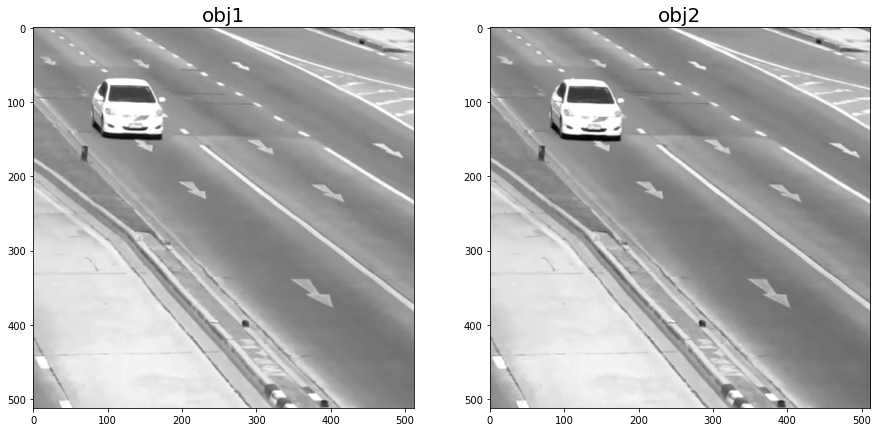

In [9]:
obj1 = io.imread('./-33.36.png').astype(int)
obj2 = io.imread('./0.png').astype(int)

fig, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].set_title('obj1',fontsize=20)
axes[1].set_title('obj2',fontsize=20)
axes[0].imshow(obj1,cmap='gray')
axes[1].imshow(obj2,cmap='gray')

## Calculate gradients
Calculate the gradient of direction X and Y as well as the norm of these two directions by the convolutional kernel:
$$G_{x}=\frac{1}{2}\left[\begin{array}{ccc}
1 & 0 & -1
\end{array}\right] \quad G_{y}=\frac{1}{2}\left[\begin{array}{c}
1 \\
0 \\
-1
\end{array}\right]$$

In [10]:
gx = 0.5*np.array([1,0,-1]).reshape(1,-1)
gy = np.transpose(gx)

gradientx = filters.convolve(obj1,gx)
gradienty = filters.convolve(obj2,gy)
gradientxy = np.sqrt(gradientx**2 + gradienty**2)

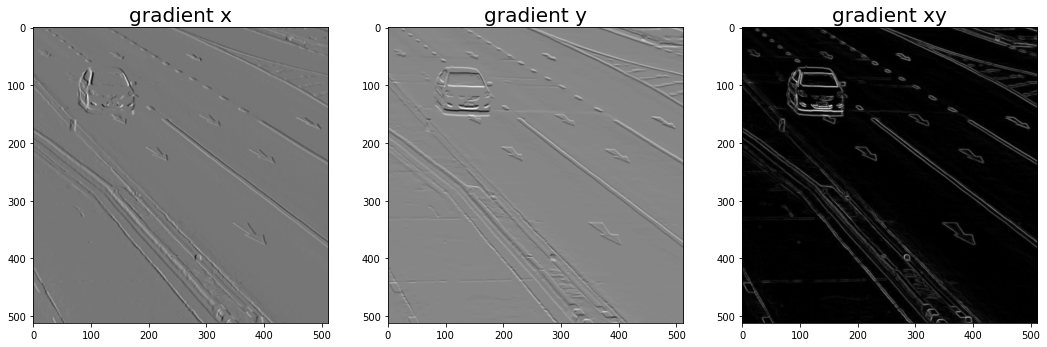

In [11]:
fig, axes = plt.subplots(1,3,figsize=(18,9))
axes[0].set_title('gradient x',fontsize=20)
axes[1].set_title('gradient y',fontsize=20)
axes[2].set_title('gradient xy',fontsize=20)

axes[0].imshow(gradientx,cmap='gray')
axes[1].imshow(gradienty,cmap='gray')
axes[2].imshow(gradientxy,cmap='gray')

# Optical flow calculation
We consider that in an image frame $\Omega$ of dimension $N \times N$ pixel, For each point $(u, v) \in \Omega$, the equation for the movement is:
$$\underbrace{I(u, v, t+d t)-I(u, v, t)}_{\Delta I(u, v)}+\frac{\partial I}{\partial u} \cdot d x+\frac{\partial I}{\partial v} \cdot d y=0$$
We can write this equation in matrix form: $A\times d = B$ with $d=\left(\begin{array}{l}d x \\ d y\end{array}\right)$ where:
$$A=\left[\begin{array}{cc}
\frac{\partial I}{\partial u_{0}} & \frac{\partial I}{\partial v_{0}} \\
\frac{\partial I}{\partial u_{0}} & \frac{\partial I}{\partial v_{1}} \\
\vdots & \vdots \\
\frac{\partial I}{\partial u_{N-1}} & \frac{\partial I}{\partial v_{N-1}}
\end{array}\right]\\
\\
B=\left[\begin{array}{c}
-\Delta I\left(u_{0}, v_{0}\right) \\
-\Delta I\left(u_{0}, v_{1}\right) \\
\vdots \\
-\Delta I\left(u_{N-1}, v_{N-1}\right)
\end{array}\right]$$

We can resolve this equation by least square method,becuase we have N equations and 2 unknowns:
$$d=\left(A^{T} A\right)^{-1} A^{T} B$$
By resolving this equation, we can have dx and dy
We estimate the optical flow of each pixel at position (x, y) by it's neighborhood $\theta = \left\{(x+u-(k / 2), y+v-(k / 2)) \backslash(u, v) \in[[0 ; k-1]]^{2}\right\}$ where k is a hyper parameter, we take between 5 to 50 pixels.


In [12]:
def deplacement(gradx,grady,diff, x,y,N):
    omx = gradx[x-(N//2):x+(N//2),y-(N//2):y+(N//2)].reshape(-1,1)
    omy = grady[x-(N//2):x+(N//2),y-(N//2):y+(N//2)].reshape(-1,1)
    A = np.concatenate((omx,omy),axis=1 )
    At = A.transpose()
    B = -diff[x-(N//2):x+(N//2),y-(N//2):y+(N//2)].reshape(-1,1)
    d = np.linalg.inv(At@A)@At@B
    return d

def img_flot(im, diff, gx, gy, N = 31):
    X = range(im.shape[0])
    Y = range(im.shape[1])
    flot = np.zeros([im.shape[0], im.shape[1], 2])
    for x in X[N//2:im.shape[0] - N//2 + 1]:
        for y in Y[N//2:im.shape[1] - N//2 + 1]:
            d = deplacement(gx, gy, diff, x, y, N)
            flot[x][y][0] = d[0]
            flot[x][y][1] = d[1]
    return flot

In [13]:
diff = obj2 - obj1
flot = img_flot(obj1, diff, gradientx, gradienty, 28)

## Show optical flow

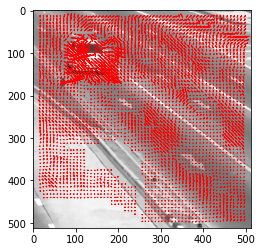

In [14]:
plt.imshow(obj1, cmap='gray')
X = range(flot.shape[0]//8)
Y = range(flot.shape[1]//8)
for i in X:
    for j in Y:
        x = i * 8
        y = j * 8
        plt.arrow(y, x, flot[x][y][0]*10, flot[x][y][1]*10, head_width=1, length_includes_head=True, color='r')

## Show Mask by setting a threshold

/home/yunfei/anaconda3/envs/redhen/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


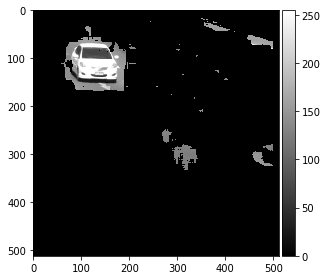

In [16]:
threshold = 1
flot_mask = np.zeros(obj1.shape)
m = flot[:,:,0]**2 + flot[:,:,1]**2 > threshold
flot_mask[m] = obj1[m]
io.imshow(flot_mask, cmap='gray')

In [19]:
h,w = obj1.shape
flot_map = np.zeros((h, w, 2))

In [20]:
flot_map[m,:] = flot[m,:]

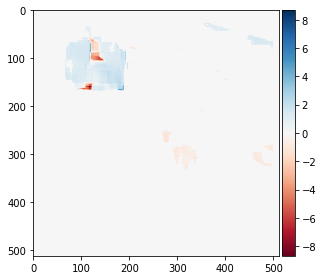

In [21]:
io.imshow(flot_map[:,:,0])

# New image prediction

In [22]:
def predict_image(first_object_image, flot, time, threshold = 1):
    predict_image = io.imread('./ground.png').astype(int)
    X = range(flot.shape[0])
    Y = range(flot.shape[1])
    for i in X:
        for j in Y:
            if flot[i,j,0]**2 + flot[i,j,1]**2 > threshold:
                vx = flot[i,j,0]/33.36
                vy = flot[i,j,1]/33.36
                dx = int(vx * (time + 33.36))
                dy = int(vy * (time + 33.36))
                predict_image[i+dx, j+dy] = first_object_image[i, j]
    return predict_image

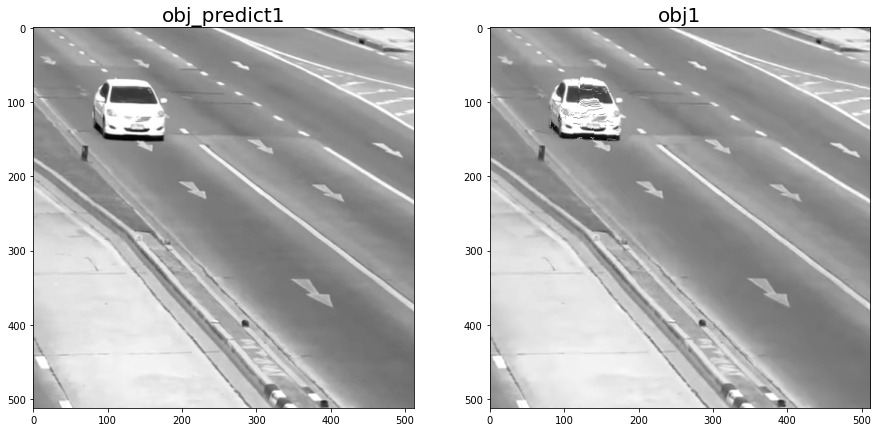

In [23]:
obj_predict1 = predict_image(obj1, flot, 1)
obj1 = io.imread('./1.png').astype(int)
fig, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].set_title('obj_predict1',fontsize=20)
axes[1].set_title('obj1',fontsize=20)
axes[0].imshow(obj1,cmap='gray')
axes[1].imshow(obj_predict1,cmap='gray')

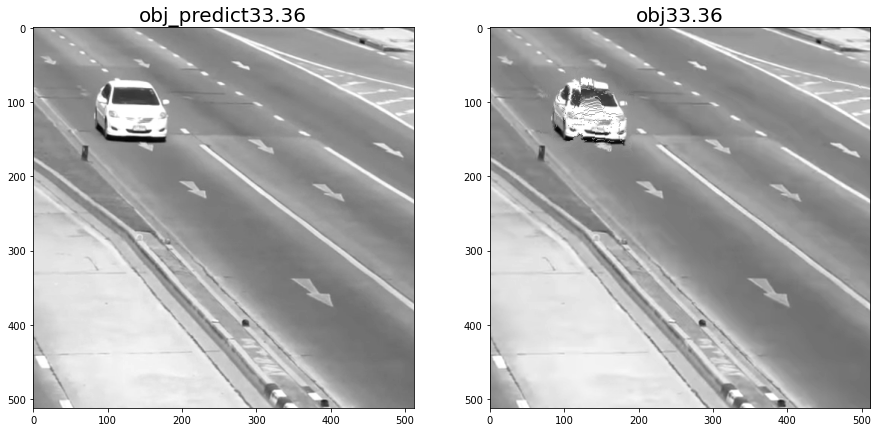

In [24]:
obj33 = io.imread('./33.36.png').astype(int)
obj_predict33 = predict_image(obj33, flot, 33.36)
fig, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].set_title('obj_predict33.36',fontsize=20)
axes[1].set_title('obj33.36',fontsize=20)
axes[0].imshow(obj33,cmap='gray')
axes[1].imshow(obj_predict33,cmap='gray')

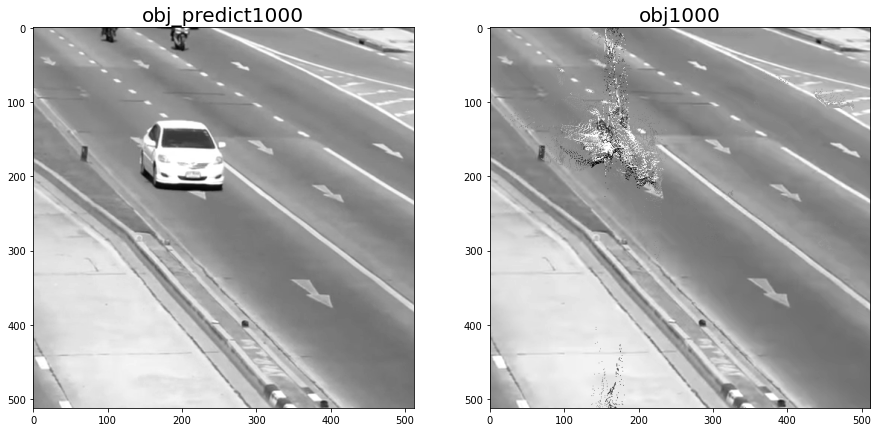

In [134]:
obj1000 = io.imread('./1000.png').astype(int)
obj_predict1000 = predict_image(obj1, flot, 1000)
fig, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].set_title('obj_predict1000',fontsize=20)
axes[1].set_title('obj1000',fontsize=20)
axes[0].imshow(obj1000,cmap='gray')
axes[1].imshow(obj_predict1000,cmap='gray')

# Contour mask

In [25]:
image = cv2.imread("-33.36.png",cv2.IMREAD_GRAYSCALE)

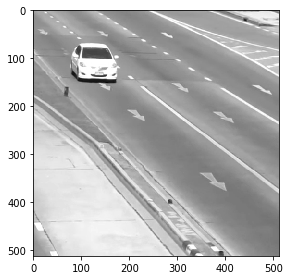

In [26]:
io.imshow(image,cmap='gray')

In [29]:
th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

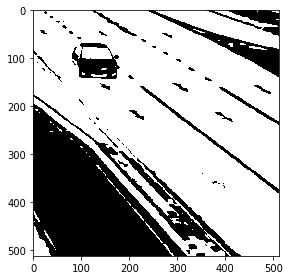

In [30]:
blur = cv2.GaussianBlur(image,(5,5),0)
ret,thresh = cv2.threshold(blur,0,255,9)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
io.imshow(thresh)

image = cv2.imread("-33.36.png",cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(image,(5,5),0)
ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_obj = [contour for contour in contours if len(contour) > 100]
cv2.drawContours(image, contours_obj, -1, (0,255,0), 3)
io.imshow(image)

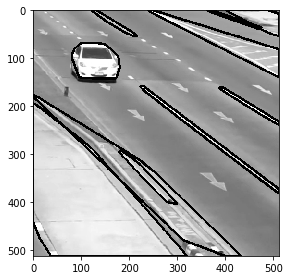

In [31]:
# convex hull
image = cv2.imread("-33.36.png",cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(image,(5,5),0)
ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_obj = [cv2.convexHull(contour) for contour in contours if len(contour) > 100]
cv2.drawContours(image, contours_obj, -1, (0,255,0), 3)
io.imshow(image)

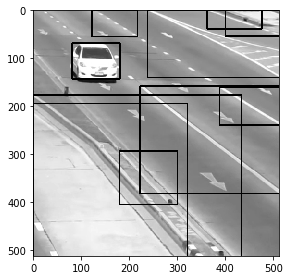

In [157]:
# Rectangle contour
image = cv2.imread("-33.36.png",cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(image,(5,5),0)
ret,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_obj = []
rectangles_obj = []
for cnt in contours:
    if len(cnt) > 100:
        x,y,w,h = cv2.boundingRect(cnt)
        box = [[x, y], [x, y+h], [x + w, y + h], [x+w, y]]
        box = np.int0(box)
        contours_obj.append(box)
        rectangles_obj.append([x, y, w, h])
        
cv2.drawContours(image, contours_obj, -1, (0,255,1000), 2)
io.imshow(image)

In [144]:
# x,y,w,h (x horizental, y verticle)
rectangles_obj = np.array(rectangles_obj)
rectangles_obj

array([[179, 293, 121, 111],
       [  0, 194, 321, 318],
       [  0, 176, 434, 336],
       [388, 161, 124,  78],
       [222, 158, 290, 224],
       [ 81,  68, 100,  75],
       [400,   0, 112,  54],
       [362,   0, 114,  39],
       [238,   0, 274, 140],
       [122,   0,  95,  55]])

# Combination of rectangle contour and flot map

In [361]:
flot_map.shape

(512, 512, 2)

In [158]:
rectangle_mean_flot = []
for rect_cnt in rectangles_obj:
    x, y, w, h = rect_cnt[0], rect_cnt[1], rect_cnt[2], rect_cnt[3]
    rect_flot = flot_map[y:y + h, x:x + w]
    mean_flot = np.sum(rect_flot, axis=(0,1))/(h*w*33.36)
    rectangle_mean_flot.append(mean_flot)

In [159]:
rectangle_mean_flot

[array([-0.00022912, -0.00022677]),
 array([-0.00027141, -0.00029122]),
 array([-0.00025811, -0.00030848]),
 array([0., 0.]),
 array([-0.0008196 , -0.00094652]),
 array([0.02579289, 0.03183506]),
 array([ 2.27014853e-04, -7.06336827e-05]),
 array([ 0.00146736, -0.00075885]),
 array([ 0.00092451, -0.0004045 ]),
 array([0., 0.])]

In [155]:
x, y,w,h =  [68,  81, 75,  100]
obj1[x:x+w, y:y+h]

array([[148, 148, 148, ..., 134, 135, 136],
       [148, 148, 148, ..., 132, 133, 134],
       [147, 148, 148, ..., 131, 132, 132],
       ...,
       [138, 137, 134, ..., 156, 154, 155],
       [139, 136, 132, ..., 155, 155, 154],
       [139, 137, 134, ..., 155, 155, 155]])

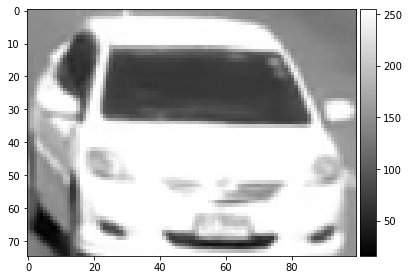

In [156]:
io.imshow(obj1[x:x+w, y:y+h], cmap='gray')

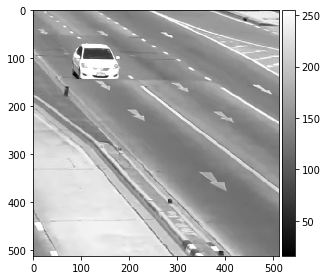

In [166]:
time = 33.36
predict_image = predict_image = io.imread('./ground.png').astype(int)
for i, object_mean_flot in enumerate(rectangle_mean_flot):
    if object_mean_flot[0]**2 + object_mean_flot[1]**2 > 10e-6: # should move at least 1 pixel in 1000ms
        x, y, w, h = rectangles_obj[i]
        x_pred = int(x + object_mean_flot[1]*time)
        y_pred = int(y + object_mean_flot[0]*time)
        predict_image[y_pred:y_pred + h, x_pred:x_pred + w] = obj1[y:y+h, x:x+w]
io.imshow(predict_image, cmap='gray')

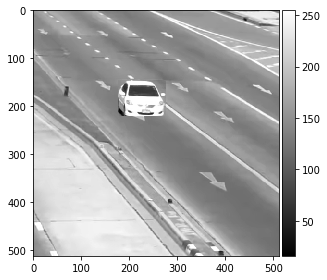

In [170]:
time = 3000
predict_image = predict_image = io.imread('./ground.png').astype(int)
for i, object_mean_flot in enumerate(rectangle_mean_flot):
    if object_mean_flot[0]**2 + object_mean_flot[1]**2 > 10e-6: # should move at least 1 pixel in 1000ms
        x, y, w, h = rectangles_obj[i]
        x_pred = int(x + object_mean_flot[1]*time)
        y_pred = int(y + object_mean_flot[0]*time)
        predict_image[y_pred:y_pred + h, x_pred:x_pred + w] = obj1[y:y+h, x:x+w]
io.imshow(predict_image, cmap='gray')

In [92]:
rectangle_mean_flot[3][0]**2 + rectangle_mean_flot[3][1]**2 > 10e-6 # should move at least 1 pixel in 1000ms

False

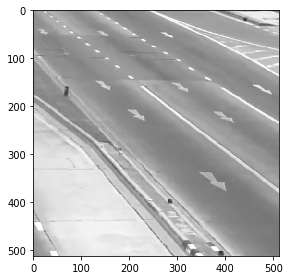

In [95]:
io.imshow(ground)

In [106]:
a = np.array([1,2,3])

In [107]:
a[4:5] = 1

/home/yunfei/anaconda3/envs/redhen/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


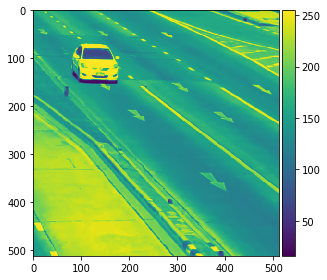

In [114]:
io.imshow(obj1)